# Test Keras GazeML implementation

**Note:** Importing cv2 can be problematic in jupyter due to issues with thread local storage (TLS)
Importing cv3 first works most of the time. If it fails restart the python kernel and try again until it works.    

In [1]:
import cv2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import dlib

# Load Neural networks

**Note:** this takes a long time on the Jetson Nano

In [3]:
%%time
MODEL_DIR = './3rdparty/'
FACE_DETECTION_MODEL = MODEL_DIR + 'haarcascade_frontalface_default.xml'
CNN_FACE_DETECTION_MODEL = MODEL_DIR + 'mmod_human_face_detector.dat'
LANDMARK_DETECTION_MODEL = MODEL_DIR + 'shape_predictor_68_face_landmarks.dat'
LANDMARK_5POINTS_DETECTION_MODEL = MODEL_DIR + 'shape_predictor_5_face_landmarks.dat'

cnn_face_detector = dlib.cnn_face_detection_model_v1(CNN_FACE_DETECTION_MODEL)
landmark_predictor = dlib.shape_predictor(LANDMARK_DETECTION_MODEL)

CPU times: user 2.89 s, sys: 232 ms, total: 3.12 s
Wall time: 3.32 s


In [4]:
%%time
from elg_keras import KerasELG

iris_model = KerasELG()
iris_model.net.load_weights("./3rdparty/elg_keras.h5")

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn


CPU times: user 1min 37s, sys: 4.25 s, total: 1min 42s
Wall time: 2min 11s


In [5]:
def detect_face_cnn(gray):
    face_locations = cnn_face_detector(gray)
    if face_locations:
        faces_area = np.array([face.rect.area() for face in face_locations], dtype=np.int)
        biggest_face = np.argmax(faces_area)
        bounding_rect = face_locations[biggest_face].rect
        return np.array([bounding_rect.left(),
                         bounding_rect.top(),
                         bounding_rect.width(),
                         bounding_rect.height()], dtype=np.int)
    else:
        return None

In [6]:
def detect_landmarks_68(gray, rect):
    landmarks = landmark_predictor(gray, rect)
    points = [(p.x, p.y) for p in landmarks.parts()]
    landmark_dict = {
        "chin": points[0:17],
        "left_eyebrow": points[17:22],
        "right_eyebrow": points[22:27],
        "nose_bridge": points[27:31],
        "nose_tip": points[31:36],
        "left_eye": points[36:42],
        "right_eye": points[42:48],
        "top_lip": points[48:55] + [points[64]] + [points[63]] +
                   [points[62]] + [points[61]] + [points[60]],
        "bottom_lip": points[54:60] + [points[48]] + [points[60]] + [points[67]] +
                      [points[66]] + [points[65]] + [points[64]],
    }

    # map to equivalent points in the 5 point landmarks
    five_pt_landmarks = [points[45], points[42], points[36], points[39], points[33]]

    landmark_dict = {k: np.array(v, dtype=np.int) for k, v in landmark_dict.items()}
    return (landmark_dict, five_pt_landmarks)

# Load test image

In [7]:
#fn = "./test_imgs/Lenna.png"
fn = "./test_imgs/wilfried2.png"
#fn = "./test_imgs/Anja.jpg"
input_img = cv2.imread(fn)[..., ::-1]

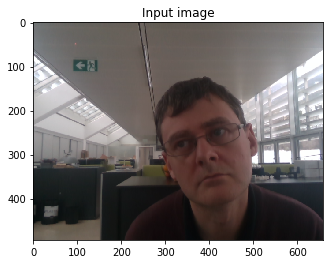

In [8]:
plt.title('Input image')
plt.imshow(input_img)

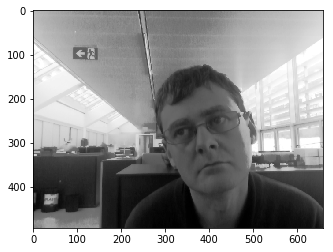

In [9]:
gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
gray = cv2.equalizeHist(gray)

plt.imshow(gray, cmap='gray')

# Face detection

In [10]:
%%time
face_bounding_box = detect_face_cnn(gray)
print(face_bounding_box)

[307 216 165 165]
CPU times: user 1.97 s, sys: 5.88 s, total: 7.85 s
Wall time: 53.5 s


In [11]:
%%time
x, y, w, h = tuple(face_bounding_box)
landmarks_68, landmarks_5 = detect_landmarks_68(gray,
                                                dlib.rectangle(x, y, x + w, y + h))
print(landmarks_5)

[(427, 250), (400, 260), (328, 282), (359, 273), (399, 323)]
CPU times: user 20 ms, sys: 140 ms, total: 160 ms
Wall time: 318 ms


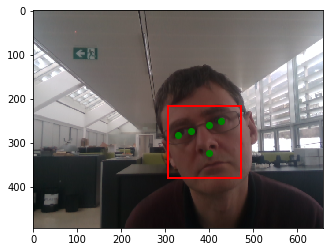

In [12]:
xs, ys = map(list, zip(*landmarks_5))
plt.imshow(input_img)
plt.plot(xs, ys, 'ro', color='g')
ax = plt.gca()
from matplotlib.patches import Rectangle
x, y, w, h = tuple(face_bounding_box)
rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

# Compute Eye region

In [13]:
lms = landmarks_5
right_eye_xy = (np.array(lms[0]) + np.array(lms[1])) / 2
left_eye_xy  = (np.array(lms[3]) + np.array(lms[2])) / 2

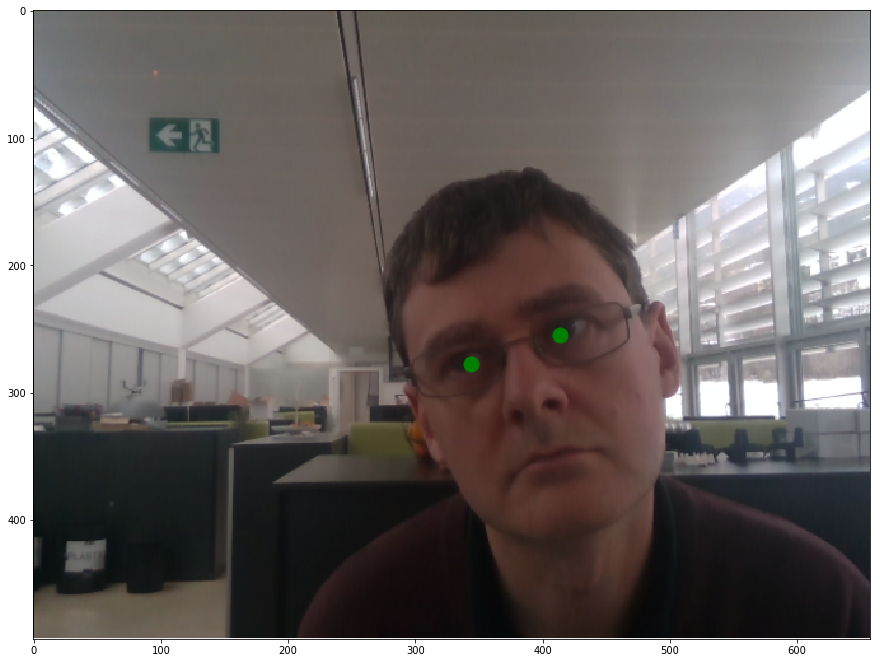

In [14]:
plt.figure(figsize=(15,15))
plt.imshow(input_img)
plt.plot([left_eye_xy[0], right_eye_xy[0]], [left_eye_xy[1], right_eye_xy[1]], 'ro', color='g', markersize=15)
plt.show()

# Advanced eye image extraction

In [15]:
def segment_eyes(frame, landmarks, eye_image_shape = (108, 180)):
    lms = np.array(landmarks)
    eyes = []
    oh, ow = eye_image_shape

    for corner1, corner2, is_left in [(2, 3, True), (0, 1, False)]:
        # left and right eye corners
        x1, y1 = lms[corner1, :]
        x2, y2 = lms[corner2, :]
        # width of eye
        eye_width = 1.5 * np.linalg.norm(lms[corner1, :] - lms[corner2, :])
        # center of eye
        cx, cy = 0.5 * (x1 + x2), 0.5 * (y1 + y2)

        # center image on middle of eye
        translate_mat = np.asmatrix(np.eye(3))
        translate_mat[:2, 2] = [[-cx], [-cy]]
        inv_translate_mat = np.asmatrix(np.eye(3))
        inv_translate_mat[:2, 2] = -translate_mat[:2, 2]

        # rotate to be upright
        roll = 0.0 if x1 == x2 else np.arctan((y2 - y1) / (x2 - x1))
        rotate_mat = np.asmatrix(np.eye(3))
        cos = np.cos(-roll)
        sin = np.sin(-roll)
        rotate_mat[0, 0] = cos
        rotate_mat[0, 1] = -sin
        rotate_mat[1, 0] = sin
        rotate_mat[1, 1] = cos
        inv_rotate_mat = rotate_mat.T

        # scale
        scale = ow / eye_width
        scale_mat = np.asmatrix(np.eye(3))
        scale_mat[0, 0] = scale_mat[1, 1] = scale
        inv_scale = 1.0 / scale
        inv_scale_mat = np.asmatrix(np.eye(3))
        inv_scale_mat[0, 0] = inv_scale_mat[1, 1] = inv_scale

        # center image
        centre_mat = np.asmatrix(np.eye(3))
        centre_mat[:2, 2] = [[0.5 * ow], [0.5 * oh]]
        inv_centre_mat = np.asmatrix(np.eye(3))
        inv_centre_mat[:2, 2] = -centre_mat[:2, 2]

        transform_mat = centre_mat * scale_mat * rotate_mat * translate_mat
        inv_transform_mat = inv_translate_mat * inv_rotate_mat * inv_scale_mat * inv_centre_mat
        
        eye_image = cv2.warpAffine(frame, transform_mat[:2, :], (ow, oh))
        if is_left:
            eye_image = np.fliplr(eye_image)
        
        eyes.append({
                    'image': eye_image,
                    'inv_landmarks_transform_mat': inv_transform_mat,
                    'side': 'left' if is_left else 'right',
                    'corners': [(x1, y1), (x2, y2)]
                })
    return eyes

In [16]:
eye_image_shape = (140, 180)
eyes = segment_eyes(input_img, landmarks_5, eye_image_shape=eye_image_shape)

left_eye_im = eyes[0]['image']
right_eye_im = eyes[1]['image']

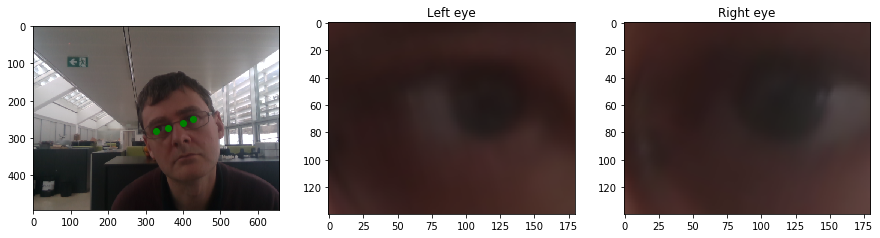

In [ ]:
plt.figure(figsize=(15,4))
plt.title('Annotation')
plt.subplot(1,3,1)
plt.imshow(input_img)
xs, ys = zip(*(eyes[0]['corners'] + eyes[1]['corners']))
plt.plot(xs, ys, 'ro', color='g')
plt.subplot(1,3,2)
plt.title('Left eye')
plt.imshow(left_eye_im)
plt.subplot(1,3,3)
plt.title('Right eye')
plt.imshow(right_eye_im)

# Prepocess Eye images

In [ ]:
shape = (eye_image_shape[1], eye_image_shape[0])
inp_left = cv2.cvtColor(left_eye_im, cv2.COLOR_RGB2GRAY)
inp_left = cv2.equalizeHist(inp_left)
inp_left = cv2.resize(inp_left, shape)[np.newaxis, ..., np.newaxis]

inp_right = cv2.cvtColor(right_eye_im, cv2.COLOR_RGB2GRAY)
inp_left = cv2.resize(inp_left, shape)[np.newaxis, ..., np.newaxis]
inp_right = cv2.equalizeHist(inp_right)

In [ ]:
inp_left.shape

In [ ]:
inp_right.shape

In [ ]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.title('Left eye')
plt.imshow(inp_left[0,...,0], cmap="gray")
plt.subplot(1,2,2)
plt.title('Right eye')
plt.imshow(inp_right[0,...,0], cmap="gray")

# Predict iris landmarks

In [ ]:
%%time
input_array = np.concatenate([inp_left, inp_right], axis=0)
pred_left, pred_right = iris_model.net.predict(input_array/255 * 2 - 1)

# Visualize output heatmaps

Eighteen heatmaps are predicted: 
- Eight heatmaps for iris (green)
- Eight heatmaps for eye-lid (red)
- Two heatmaps for pupil (blue)

In [ ]:
def stretch_color(x):
    minimum = np.min(x)
    maximum = np.max(x)
    return ((x - minimum) / (maximum - minimum) * 255).astype(np.uint8)

In [ ]:
hm_r = stretch_color(np.sum(pred_left[...,:8], axis=-1, keepdims=True))
hm_g = stretch_color(np.sum(pred_left[...,8:16], axis=-1, keepdims=True))
hm_b = stretch_color(np.sum(pred_left[...,16:], axis=-1, keepdims=True))
heatmaps_left = np.concatenate([hm_r, hm_g, hm_b], axis=-1)

In [ ]:
hm_r = stretch_color(np.sum(pred_right[...,:8], axis=-1, keepdims=True))
hm_g = stretch_color(np.sum(pred_right[...,8:16], axis=-1, keepdims=True))
hm_b = stretch_color(np.sum(pred_right[...,16:], axis=-1, keepdims=True))
heatmaps_right = np.concatenate([hm_r, hm_g, hm_b], axis=-1)

In [ ]:
color_imageplt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.axis('off')
plt.title('Left eye heatmaps')
plt.imshow(heatmaps_left)
plt.subplot(2,2,2)
plt.axis('off')
plt.title('Right eye heatmaps')
plt.imshow(heatmaps_right)
plt.subplot(2,2,3)
plt.title('Left eye')
plt.imshow(inp_left[0,...,0], cmap="gray")
plt.subplot(2,2,4)
plt.title('Right eye')
plt.imshow(inp_right[0,...,0], cmap="gray")

# Draw eye region landmarks

In [ ]:
def draw_pupil(im, inp_im, lms):
    draw = im.copy()
    draw = cv2.resize(draw, (inp_im.shape[2], inp_im.shape[1]))
    pupil_center = np.zeros((2,))
    pnts_outerline = []
    pnts_innerline = []
    stroke = 2 #inp_im.shape[1] // 12 + 1
    for i, lm in enumerate(np.squeeze(lms)):
        y, x = int(lm[0]*3), int(lm[1]*3)

        if i < 8:
            draw = cv2.circle(draw, (y, x), stroke, (125,255,125), -1)
            pnts_outerline.append([y, x])
        elif i < 16:
            draw = cv2.circle(draw, (y, x), stroke, (125,125,255), -1)
            pnts_innerline.append([y, x])
            pupil_center += (y,x)
        elif i < 17:
            draw = cv2.drawMarker(draw, (y, x), (255,200,200), markerType=cv2.MARKER_SQUARE, markerSize=5, thickness=stroke, line_type=cv2.LINE_AA)
        else:
            draw = cv2.drawMarker(draw, (y, x), (255,125,125), markerType=cv2.MARKER_STAR, markerSize=5, thickness=stroke, line_type=cv2.LINE_AA)
    pupil_center = (pupil_center/8).astype(np.int32)
    draw = cv2.circle(draw, (pupil_center[0], pupil_center[1]), stroke, (255,255,0), -1)        
    draw = cv2.polylines(draw, [np.array(pnts_outerline).reshape(-1,1,2)], isClosed=True, color=(125,255,125), thickness=stroke//2)
    draw = cv2.polylines(draw, [np.array(pnts_innerline).reshape(-1,1,2)], isClosed=True, color=(125,125,255), thickness=stroke//2)
    return draw

In [ ]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.title("Left eye")
lms_left = iris_model._calculate_landmarks(pred_left)
result_left = draw_pupil(left_eye_im, inp_left, lms_left)
plt.imshow(result_left)
plt.subplot(1,2,2)
plt.title("Right eye")
lms_right = iris_model._calculate_landmarks(pred_right)
result_right = draw_pupil(right_eye_im, inp_right, lms_right)
plt.imshow(result_right)

In [ ]:
draw2 = input_img.copy()

slice_h = slice(int(left_eye_xy[1]-eye_bbox_h//2), int(left_eye_xy[1]+eye_bbox_h//2))
slice_w = slice(int(left_eye_xy[0]-eye_bbox_w//2), int(left_eye_xy[0]+eye_bbox_w//2))
im_shape = left_eye_im.shape[::-1]

draw2[slice_h, slice_w, :] = cv2.resize(result_left[:,::-1,:], im_shape[1:])

slice_h = slice(int(right_eye_xy[1]-eye_bbox_h//2), int(right_eye_xy[1]+eye_bbox_h//2))
slice_w = slice(int(right_eye_xy[0]-eye_bbox_w//2), int(right_eye_xy[0]+eye_bbox_w//2))
im_shape = right_eye_im.shape[::-1]

draw2[slice_h, slice_w, :] = cv2.resize(result_right, im_shape[1:])

plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(draw2)